# RNN伪代码

In [ ]:
# t时刻的状态
state_t = 0
# 对序列元素进行遍历
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    # 前一次的输出,变成下一次迭代的状态
    state_t = output_t

# 更详细的RNN伪代码

In [ ]:
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

# 简单RNN的numpy实现

In [3]:
import numpy as np

# 输入序列的时间步数
timesteps = 100
# 输入特征空间的维度
input_features = 32
# 输出特征空间的维度
output_features = 64

# 输入数据:随机噪声,仅作为示例
inputs = np.random.random((timesteps, input_features))
# 初始状态:全0向量
state_t = np.zeros((output_features,))
# 创建随机的权重矩阵
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = list()
# input_t是形状为(input_features, )的向量
for input_t in inputs:
    # 由输入和当前的状态计算得到当前输出
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    # 将这个输出保存到一个列表中
    successive_outputs.append(output_t)
    # 更新网络的状态,用于下一个时间步
    state_t = output_t
# 最终输出是一个形状为(timesteps, output_features)的二维张量
final_output_sequence = np.stack(successive_outputs, axis=0)

# Keras中的循环层

In [6]:
# SimpleRNN层能够像替他Keras层一样处理序列批量.
# SimpleRNN可以在两种不同的模式下运行:
#     一种是返回每个时间步连续输出的完整序列,即形状为(batch_size, timesteps, output_features)
#     另外一种是只返回每个输入序列的最终结果,即形状为(batch_size, output_features)
#     这两种模式由return_sequences这个构造函数参数来控制

In [7]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Embedding
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [10]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 为了提高网络的表示能力,将多个循环层逐个堆叠有时也是很有用的.在这种情况下,你需要让所有中间层都返回完整的输出序列
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


# 准备IMDB数据

In [13]:
from keras.datasets import imdb
from keras.preprocessing import sequence
# 作为特征的单词个数
max_features = 10000
# 在这么多单词之后截断文本
maxlen = 500
batch_size = 32
print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape: ', input_train.shape)
print('input_test shape: ', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape:  (25000, 500)
input_test shape:  (25000, 500)


## 用Embedding层和一个SimpleRNN层来训练一个简单的循环网络

In [14]:
from keras.layers import Dense

In [15]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)
history = model.fit(
    input_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 14s 699us/step - loss: 0.6409 - acc: 0.6135 - val_loss: 0.5537 - val_acc: 0.7176
Epoch 2/10
20000/20000 [==============================] - 14s 682us/step - loss: 0.4086 - acc: 0.8222 - val_loss: 0.5247 - val_acc: 0.7410
Epoch 3/10
20000/20000 [==============================] - 13s 668us/step - loss: 0.2868 - acc: 0.8867 - val_loss: 0.3743 - val_acc: 0.8354
Epoch 4/10
20000/20000 [==============================] - 13s 669us/step - loss: 0.2565 - acc: 0.9020 - val_loss: 0.4008 - val_acc: 0.8394
Epoch 5/10
20000/20000 [==============================] - 13s 664us/step - loss: 0.1626 - acc: 0.9400 - val_loss: 0.3656 - val_acc: 0.8722
Epoch 6/10
20000/20000 [==============================] - 13s 669us/step - loss: 0.1037 - acc: 0.9642 - val_loss: 0.4338 - val_acc: 0.8386
Epoch 7/10
20000/20000 [==============================] - 13s 660us/step - loss: 0.0673 - acc: 0.9797 - val_loss: 0.4

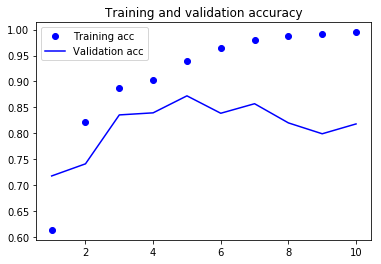

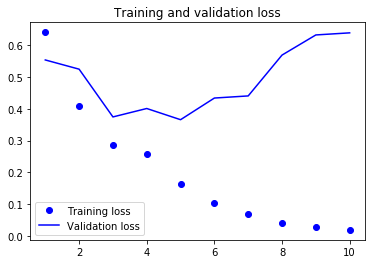

In [17]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# 验证精度只有85%,问题部分原因在于,输入只考虑了前500个单词,而不是整个序列,因此,RNN获得的信息比前面的基准模型更少.
# 另一部分原因在于,SimpleRNN不擅长处理长序列,比如文本.

In [19]:
model.evaluate(input_test, y_test)

25000/25000 [==============================] - 15s 606us/step


[0.6600112350559234, 0.81536]

# 使用Keras中的LSTM层

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 60s 3ms/step - loss: 0.5106 - acc: 0.7602 - val_loss: 0.4270 - val_acc: 0.8372
Epoch 2/10
20000/20000 [==============================] - 59s 3ms/step - loss: 0.2941 - acc: 0.8836 - val_loss: 0.3897 - val_acc: 0.8430
Epoch 3/10
20000/20000 [==============================] - 60s 3ms/step - loss: 0.2383 - acc: 0.9102 - val_loss: 0.2839 - val_acc: 0.8914
Epoch 4/10
20000/20000 [==============================] - 60s 3ms/step - loss: 0.2018 - acc: 0.9261 - val_loss: 0.4260 - val_acc: 0.8726
Epoch 5/10
20000/20000 [==============================] - 59s 3ms/step - loss: 0.1771 - acc: 0.9345 - val_loss: 0.4104 - val_acc: 0.8610
Epoch 6/10
20000/20000 [==============================] - 59s 3ms/step - loss: 0.1563 - acc: 0.9444 - val_loss: 0.3394 - val_acc: 0.8888
Epoch 7/10
20000/20000 [==============================] - 60s 3ms/step - loss: 0.1454 - acc: 0.9472 - val_loss: 0.2947 - val_acc:

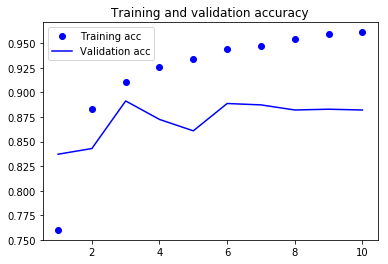

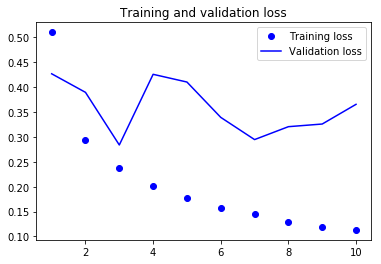

In [22]:
from keras.layers import LSTM
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    input_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2
)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [24]:
model.evaluate(input_test, y_test)

25000/25000 [==============================] - 60s 2ms/step


[0.43735654586791994, 0.86212]